In [5]:
import os,sys,re
import scipy.spatial as spt
import numpy as np
import h5py
import illustris_tools as it
import illustris_python as il

def nn_dist(args):
    smoothlength,point,tree = args
    return tree.query(point,k=smoothlength)[0][-1]

def skirt_requirements(snap,sub,tmp_path,sim_tag='TNG50-1',
                       pixelsize=100.,fovsize_hmr=15.,smoothlength=32):
    '''
    pixel_size: output pixel size in physical [pc]
    fovsize_hmr: size of fov in stellar half mass radius units
    smooth_length: kernel smoothing length of stellar particles (nn distance)
    '''

    #basepath where TNG data is stored
    basePath = f'/home/bottrell/scratch/Simulations/{sim_tag}/output'

    #load current scale factor
    header = dict(h5py.File(f'{basePath}/snapdir_{snap:03d}/snap_{snap:03d}.0.hdf5',"r")["Header"].attrs.items())
    a2 = header["Time"]

    #take fov_size times stellar halfmassradius in proper pc as boxsize for dust calcualtion in SKIRT 
    fovsize = it.convertlength(il.groupcat.loadSingle(basePath,snap,subhaloID=sub)["SubhaloHalfmassRadType"][4])
    fovsize *= a2*fovsize_hmr*1000 # pc

    npix = np.ceil(fovsize/pixelsize).astype(int)

    if fovsize == 0:
        print("Not a valid subhalo, I will stop now and running SKIRT makes no sense")
        raise SystemExit
    
    # save f_stars,f_mappings,f_gas to file
    f_stars = f'shalo_{snap:03d}-{sub}_stars.dat'
    f_mappings = f'shalo_{snap:03d}-{sub}_mappings.dat'
    f_gas = f'shalo_{snap:03d}-{sub}_gas.dat'
    
    #############
    ### Stars ###
    #############
    if not (os.access(f'{tmp_path}/{f_stars}',0) and os.access(f'{tmp_path}/{f_mappings}',0)):
        fields = ["Coordinates","GFM_StellarFormationTime","GFM_InitialMass","GFM_Metallicity", "Velocities", "Masses"]
        #load star particles
        stars = il.snapshot.loadSubhalo(basePath,snap,sub,4,fields)
        #ignore all wind particles
        if (stars["count"]!=0):
            starindex = np.where(stars["GFM_StellarFormationTime"] > 0)

        #Transform coordinates to center
        centerGal=il.groupcat.loadSingle(basePath,snap,subhaloID=sub)["SubhaloPos"]
        old_coordinates,center = it.periodicfix(stars["Coordinates"], centerGal)
        old_coordinates = (it.convertlength(old_coordinates[starindex])*1000*a2).T
        center = (it.convertlength(center)*1000*a2)
        x,y,z = old_coordinates[0] - center[0],old_coordinates[1] - center[1],old_coordinates[2] - center[2]
        del old_coordinates, center

        #smoothing length in proper pc (distance to smoothlength closest neighbour)
        if (stars["count"]!=0):
            #create array with locations
            loc = np.array([x,y,z]).T
            #setup KDTree
            tree = spt.cKDTree(loc,leafsize = 100)

            environ = os.environ
            nthreads = int(environ['SLURM_CPUS_PER_TASK']) if 'SLURM_CPUS_PER_TASK' in environ else 1
            if nthreads>1:
                from multiprocessing import Pool
                argList = [(smoothlength,point,tree) for point in loc]
                with Pool(nthreads) as pool:
                    h = np.asarray(pool.map(nn_dist,argList))
            else:
                h = np.zeros(len(x))
                for i,point in enumerate(loc):
                    dist = tree.query(point,k=smoothlength)[0][-1]
                    h[i] = dist
                h = np.asarray(h)
        else:
            h = []

        #initial mass in solar masses
        if (stars["count"]!=0):
            M = it.convertmass(stars["GFM_InitialMass"][starindex])
        else:
            M = []

        #metallicity (actual metallicity, not in solar units)
        if (stars["count"]!=0):
            Z = stars["GFM_Metallicity"][starindex]
        else:
            Z = []

        #age of the stars in years
        if (stars["count"]!=0):
            t = it.age(stars["GFM_StellarFormationTime"][starindex],a2)
        else:
            t = []

        ### Old stars ####
        #only consider stars older than 10Myr for bruzual charlot spectra
        xb = x[t > 1e7]
        yb = y[t > 1e7]
        zb = z[t > 1e7]
        hb = h[t > 1e7]
        Mb = M[t > 1e7]
        Zb = Z[t > 1e7]
        tb = t[t > 1e7]

        #create 2D-array and write into data file
        totalb = np.column_stack((xb,yb,zb,hb,Mb,Zb,tb))
        np.savetxt(f'{tmp_path}/{f_stars}',totalb,delimiter = " ")

        ### Young stars ###
        xm = x[t <= 1e7]
        ym = y[t <= 1e7]
        zm = z[t <= 1e7]
        hm = h[t <= 1e7]
        Mm = M[t <= 1e7]
        Zm = Z[t <= 1e7]
        tm = t[t <= 1e7]

        #calculate SFR (assuming SFR has been constant in the last 10Myr)
        SFRm = Mm/1e7
        #for compactness, take typical value of 5:
        logC = np.full(len(SFRm),5)
        #for ISM pressure, take typical value log(P/kB / cm^-3K) = 5, P = 1.38e-12 N/m2
        pISM = np.full(len(SFRm),1.38e-12)
        #for PDR covering fraction, take f = 0.2
        fPDR = np.full(len(SFRm),0.2)
        #create 2D-array and write into data file
        totalm = np.column_stack((xm,ym,zm,hm,SFRm,Zm,logC,pISM,fPDR))
        np.savetxt(f'{tmp_path}/{f_mappings}',totalm,delimiter = " ")

    #############
    #### Gas ####
    #############
    fields = ["Coordinates","Density","GFM_Metallicity","InternalEnergy","ElectronAbundance","StarFormationRate"]
    #load gas particles
    gas= il.snapshot.loadSubhalo(basePath,snap,sub,0,fields=fields)
    if gas["count"] != 0:
        #Transform coordinates to center
        centerGal=il.groupcat.loadSingle(basePath,snap,subhaloID=sub)["SubhaloPos"]
        old_coordinates,center = it.periodicfix(gas["Coordinates"], centerGal)
        old_coordinates = (it.convertlength(old_coordinates)*1000*a2).T
        center = (it.convertlength(center)*1000*a2)
        xg,yg,zg = old_coordinates[0] - center[0], old_coordinates[1] - center[1], old_coordinates[2] - center[2]
        del old_coordinates, center

        rhog = it.convertdensity(gas["Density"])/((1000*a2)**3)

        #gas particle metallicity (not in solar units)
        #This will actually become the dust abundance
        Zg = gas["GFM_Metallicity"]

        #gas temperature in K
        T = it.temp(gas["InternalEnergy"],gas["ElectronAbundance"])

        #SFR of gas cell
        SFRg = gas["StarFormationRate"]

        #Calculate the dust abunndance
        #set density to zero where Temperature is above threshold value and where there is no SFR
        #Dust properties
        Tthreshold = 75000 #define temperature threshold for dust formation
        Zg[((T > Tthreshold) & (SFRg == 0))] = 0.0
        DTM = it.DTM(Zg/0.014) #gas phase metallicity in solar units
        dustAbundance = Zg * DTM 
        # set lower bound for dust abundance
        dustAbundance[np.isnan(dustAbundance)]=0.0
        del Zg, T, SFRg
    else:
        xg,yg,zg,rhog,dustAbundance = [],[],[],[],[]

    ncells = len(xg)

    #create 2D-array and write into data file
    totalg = np.column_stack((xg,yg,zg,rhog,dustAbundance))
    np.savetxt(f'{tmp_path}/{f_gas}',totalg,delimiter = " ")

    return fovsize,npix,ncells,f_stars,f_mappings,f_gas

def skirt_run(snap,sub,sim_tag='TNG50-1',tmp_path=None):
    
    snap,sub = int(snap),int(sub)
    
    ppath = '/home/bottrell/projects/def-simardl/bottrell/Simulations/IllustrisTNG'
    spath = f'{ppath}/Scripts/SKIRT'
    ski_in = f'{spath}/shalo.ski'
    opath = f'{ppath}/{sim_tag}/postprocessing/{snap:03d}'

    with open(ski_in,'r') as f:
        filedata = f.read()

    if not tmp_path:
        environ = os.environ
        if 'SLURM_TMPDIR' in environ:
            tmp_path=environ['SLURM_TMPDIR']
        else:
            # run locally in temprorary directory
            tmp_path = f'./tmp_{snap:03d}-{sub}'
            os.system(f'mkdir -p {tmp_path}')
    else:
        os.system(f'mkdir -p {tmp_path}')
    os.chdir(tmp_path)
            
    # prepare skirt output and place in tmpdir
    ski_out = f'shalo_{snap:03d}-{sub}.ski'
    
    f_wavelengths = 'wavelength.dat'
    os.system(f'cp {spath}/{f_wavelengths} {tmp_path}/{f_wavelengths}')
    
    fovsize,npix,ncells,f_stars,f_mappings,f_gas = skirt_requirements(snap,sub,tmp_path)
    
    # Replace the target string
    filedata = re.sub('_FILENAME_STARS_',f_stars,filedata)
    filedata = re.sub('_FILENAME_MAPPINGS_',f_mappings,filedata)
    filedata = re.sub('_FILENAME_GAS_',f_gas,filedata)
    filedata = re.sub('_FILENAME_WAVELENGTHS_',f_wavelengths,filedata)
    filedata = re.sub('_FOVSIZE_',str(fovsize),filedata)
    filedata = re.sub('_PIXELNUM_',str(npix),filedata)
    filedata = re.sub('_SIZE_',str(fovsize/2.),filedata)
    filedata = re.sub('_NUMCELLS_',str(ncells),filedata)
    
    with open(f'{tmp_path}/{ski_out}', 'w') as f:
        f.write(filedata)
 
    environ = os.environ
    if 'SLURM_NTASKS' in environ:
        nthreads = int(environ['SLURM_CPUS_PER_TASK'])
    else:
        nproc = 1
        nthreads = 1

    os.system(f'srun skirt -t {nthreads} {ski_out}')
    os.system(f'mdkir -p {opath}')
    os.system(f'cp {ski_out.replace(".ski","_i00_total.fits")} {opath}')
    os.system(f'rm -rf {tmp_path})
    
if __name__=='__main__':
    
    snap = 51
    sub = 4
    
    tmp_base=f'/scratch/bottrell/tmpdir'
    tmp_path=f'{tmp_base}/tmp_{snap:03d}-{sub}'
    skirt_run(snap,sub,tmp_path=tmp_path)


In [2]:
import os
tmp_path = os.environ['SLURM_TMPDIR']

f_gas = f'shalo_{snap:03d}-{sub}_gas.dat'

gas = np.loadtxt(f'{tmp_path}/{f_gas}')


In [4]:
print(len(gas),np.nanmin(gas[:,-1]))

531024 0.0


In [38]:
from multiprocessing import Pool
import time
environ = os.environ
nproc = int(environ['SLURM_CPUS_ON_NODE']) if 'SLURM_CPUS_ON_NODE' in environ else 1

x = np.arange(10)
M = np.zeros((len(x),10,10))

def worker_task(args):
    i,xi,M = args
    if i ==3:
        time.sleep(5)
    return M[i]+xi

args = [(i,xi,M) for i,xi in enumerate(x)]

pool = Pool(nproc)
results = np.asarray(pool.map(worker_task,args))
pool.close

print(results.shape)
print(results)

(10, 10, 10)
[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]

 [[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
  [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
  [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
  [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
  [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
  [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
  [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
  [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
  [2. 2. 2. 2. 2. 2. 2. 2. 2. 2

Process ForkPoolWorker-58:
Process ForkPoolWorker-60:
Process ForkPoolWorker-57:
Process ForkPoolWorker-59:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.7.4/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.7.4/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.7.4/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.7.4/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.7.4/lib/py

In [11]:
import numpy as np

# filename = 'SparseWL.dat'
# wl = np.linspace(0.1,1.1,201,endpoint=True)
# dust_wl = np.logspace(np.log10(1.1),3,10)[1:]
# wl = np.append(wl,dust_wl)
# np.savetxt(filename,wl,header=str(len(wl)),comments='')

# filename = 'FineWL.dat'
# wl = np.linspace(0.1,1.1,201,endpoint=True)
# dust_wl = np.logspace(np.log10(1.1),3,100)[1:]
# wl = np.append(wl,dust_wl)
# np.savetxt(filename,wl,header=str(len(wl)),comments='')

def create_wl_grid(filename='Wavelength_Grid.dat'):
    wl = np.linspace(0.1,1.,181,endpoint=True)
    wl = np.append(wl,np.linspace(1.,5.,21)[1:])
    np.savetxt(filename,wl,header=str(len(wl)),comments='')

# filename = 'FineWavelength_Grid.dat'
# wl = np.linspace(0.1,1.,901,endpoint=True)
# wl = np.append(wl,np.linspace(1.,5.,201)[1:])
# np.savetxt(filename,wl,header=str(len(wl)),comments='')





In [1]:
# get list of TNG subhalos in mass range from group cats
import illustris_python as il
import numpy as np

def get_subhalos(basePath,snap,mstar_lower=0,mstar_upper=np.inf):
    '''
    mstar_lower and mstar_upper have log10(Mstar/Msun) units and are physical (i.e. Msun, not Msun/h).
    '''
    from astropy.cosmology import Planck15 as cosmo
    little_h = cosmo.H0.value/100.
    
    ptNumStars = il.snapshot.partTypeNum('stars') 
    fields = ['SubhaloMassType','SubhaloFlag']
    subs = il.groupcat.loadSubhalos(basePath,snap,fields=fields)

    mstar = subs['SubhaloMassType'][:,ptNumStars]
    flags = subs['SubhaloFlag']
    subs = np.arange(subs['count'],dtype=int)
    
    # convert to units used by TNG (1e10 Msun/h)
    mstar_lower = 10**(mstar_lower)/1e10*little_h
    mstar_upper = 10**(mstar_upper)/1e10*little_h
    subs = subs[(flags!=0)*(mstar>=mstar_lower)*(mstar<=mstar_upper)]
    return subs,mstar[subs]

def main(snap):
    
    basePath = '/lustre/work/connor.bottrell/Simulations/IllustrisTNG/TNG50-1/output'
    subs,mstar = get_subhalos(basePath,snap=snap,mstar_lower=9)
    
    return subs,mstar


if __name__=='__main__':
    
    subs,mstar = main(snap=67)

    

In [2]:
from astropy.cosmology import Planck15 as cosmo
little_h = cosmo.H0.value/100.
10**9*little_h/1e10
print(subs[:100])

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  43  44  46  47  48  49  50  51  52  53  55  56
  57  58  59  60  61  62  63  64  67  68  69  70  72  74  75  76  77  78
  79  80  81  83  85  86  87  88  89  90  92  94  97  99 102 104 107 108
 110 113 116 117 122 124 128 129 132 137]


In [45]:
import os,sys,re
import scipy.spatial as spt
import numpy as np
import h5py
import illustris_tools as it
import illustris_python as il

    
    
def nn_dist(args):
    smoothlength,point,tree = args
    return tree.query(point,k=smoothlength)[0][-1]



def skirt_requirements(snap,sub,tmp_path,sim_tag='TNG50-1',
                       pixelsize=100.,fovsize_hmr=15.,smoothlength=32):
    '''
    pixel_size: output pixel size in [pc]
    fov_hmr: size of fov in stellar half mass radius units
    smooth_length: kernel smoothing length of stellar particles (nn distance)
    '''

    #basepath where TNG data is stored
    basePath = f'/home/bottrell/scratch/Simulations/{sim_tag}/output'

    #load current scale factor
    header = dict(h5py.File(f'{basePath}/snapdir_{snap:03d}/snap_{snap:03d}.0.hdf5',"r")["Header"].attrs.items())
    a2 = header["Time"]

    #take fov_size times stellar halfmassradius in proper pc as boxsize for dust calcualtion in SKIRT 
    fovsize = it.convertlength(il.groupcat.loadSingle(basePath,snap,subhaloID=sub)["SubhaloHalfmassRadType"][4])
    fovsize *= a2*fovsize_hmr*1000 # pc

    npix = np.ceil(fovsize/pixelsize).astype(int)

    if fovsize == 0:
        print("Not a valid subhalo, I will stop now and running SKIRT makes no sense")
        raise SystemExit
    
    # save f_stars,f_mappings,f_gas to file
    f_stars = f'shalo_{snap:03d}-{sub}_stars.dat'
    f_mappings = f'shalo_{snap:03d}-{sub}_mappings.dat'
    f_gas = f'shalo_{snap:03d}-{sub}_gas.dat'
    
    #############
    ### Stars ###
    #############
    fields = ["Coordinates","GFM_StellarFormationTime","GFM_InitialMass","GFM_Metallicity", "Velocities", "Masses"]
    #load star particles
    stars = il.snapshot.loadSubhalo(basePath,snap,sub,4,fields)
    #ignore all wind particles
    if (stars["count"]!=0):
        starindex = np.where(stars["GFM_StellarFormationTime"] > 0)

    #Transform coordinates to center
    centerGal=il.groupcat.loadSingle(basePath,snap,subhaloID=sub)["SubhaloPos"]
    old_coordinates,center = it.periodicfix(stars["Coordinates"], centerGal)
    old_coordinates = (it.convertlength(old_coordinates[starindex])*1000*a2).T
    center = (it.convertlength(center)*1000*a2)
    x,y,z = old_coordinates[0] - center[0],old_coordinates[1] - center[1],old_coordinates[2] - center[2]
    del old_coordinates, center
    print(len(x))

    #create 2D-array and write into data file
    totalb = np.column_stack((x,y,z))
    np.savetxt(f'{tmp_path}/{f_stars}',totalb,delimiter = " ")

    return fovsize,npix,f_stars


def run_skirt(snap,sub,sim_tag='TNG50-1',tmp_path=None):
    
    snap,sub = int(snap),int(sub)
    
    ppath = '/home/bottrell/projects/def-simardl/bottrell/Simulations/IllustrisTNG'
    spath = f'{ppath}/Scripts/SKIRT'
    ski_in = f'{spath}/shalo.ski'
    opath = f'{ppath}/{sim_tag}/postprocessing/SKIRT/{snap:03d}'

    if not tmp_path:
        environ = os.environ
        if 'SLURM_TMPDIR' in environ:
            tmp_path=environ['SLURM_TMPDIR']
        else:
            # run locally in temprorary directory
            tmp_path = f'./tmp_{snap:03d}-{sub}'
            os.system(f'mkdir -p {tmp_path}')
    else:
        os.system(f'mkdir -p {tmp_path}')
    os.chdir(tmp_path)
            
    # prepare skirt output and place in tmpdir
    ski_out = f'shalo_{snap:03d}-{sub}.ski'
    
    f_wavelengths = 'Wavelength_Grid.dat'
    os.system(f'cp {spath}/{f_wavelengths} {tmp_path}/{f_wavelengths}')
    
    fovsize,npix,f_stars = skirt_requirements(snap,sub,tmp_path)
    
    
    import matplotlib.pyplot as plt
    
    fig,ax = plt.subplots(figsize=(5,5))
    
    stars = np.loadtxt(f_stars)
    
    x,y,z = stars[:,0],stars[:,1],stars[:,2]
    
    ax.scatter(x,y,s=0.1,alpha=0.01)
    
    ax.set_xlim(-fovsize/2,fovsize/2)
    ax.set_ylim(-fovsize/2,fovsize/2)

if __name__=='__main__':
    
    snap = 51
    sub = 4

    tmp_base=f'/scratch/bottrell/tmpdir'
    tmp_path=f'{tmp_base}/tmp_{snap:03d}-{sub}'
    run_skirt(snap,sub,tmp_path=tmp_path)
        

1595206


KeyboardInterrupt: 

482.2451870644953
1.0000000036274937e-15


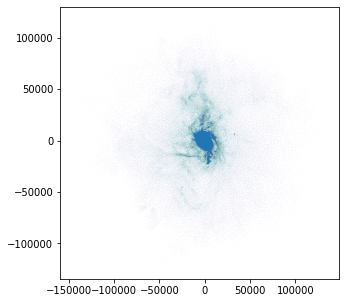

In [4]:
import numpy as np

def run_skirt(snap,sub,dist,sim_tag='TNG50-1',tmp_path=None):
    
    snap,sub = int(snap),int(sub)
    
    filename = f'{tmp_path}/shalo_{snap:03}-{sub}_{dist}.dat'
    
    import matplotlib.pyplot as plt
    fig,ax = plt.subplots(figsize=(5,5))
    parts = np.loadtxt(filename)

    print(np.sum(parts[:,4]))
    print(np.percentile(parts[:,4][parts[:,4]!=0.],0.1))
    x,y,z = parts[:,2],parts[:,1],parts[:,0]
    ax.scatter(x,y,s=0.1,alpha=0.01)
#     ax.set_xlim(-fovsize/2,fovsize/2)
#     ax.set_ylim(-fovsize/2,fovsize/2)

if __name__=='__main__':
    
    snap = 67
    sub = 505059
    dist = 'gas'

    tmp_base=f'/lustre/work/connor.bottrell/tmpdir'
    tmp_path=f'{tmp_base}/tmp_{snap:03d}-{sub}'
    run_skirt(snap,sub,dist,tmp_path=tmp_path)
        

Text(0.5, 0, '$\\lambda$ [$\\mu$m]')

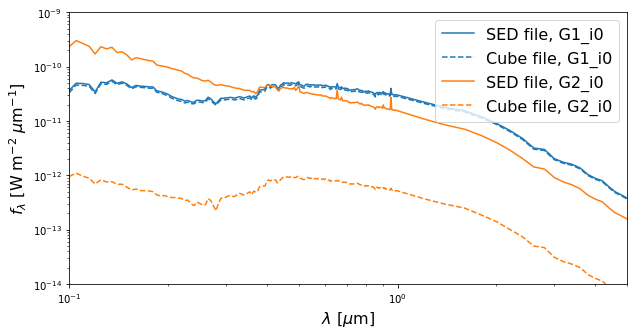

In [25]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(10,5))
ax.set_ylim(1e-14,1e-9)
ax.set_xlim(0.1,5)

arcsec2_per_str = (180./np.pi)**2*3600**2
str_per_pixel = 1e2**2/10e6**2
arcsec2_per_pixel = str_per_pixel*arcsec2_per_str

sed_name = '/home/bottrell/scratch/tmpdir/tmp_051-4/shalo_051-4_v0_sed.dat'
cube_name = '/home/bottrell/scratch/tmpdir/tmp_051-4/shalo_051-4_v0_total.fits'

sed = np.loadtxt(sed_name)
cube = np.sum(fits.getdata(cube_name),axis=(1,2))
wavelengths = np.loadtxt('Wavelength_Grid.dat')[1:]

ax.loglog(sed[:,0],sed[:,1],c='C0',label='SED file, G1_i0')
ax.loglog(wavelengths,cube*arcsec2_per_pixel,c='C0',ls='dashed',label='Cube file, G1_i0')



sed_name = '/home/bottrell/scratch/tmpdir/tmp_051-121129/shalo_051-121129_v3_sed.dat'
cube_name = '/home/bottrell/scratch/tmpdir/tmp_051-121129/shalo_051-121129_v3_total.fits'

sed = np.loadtxt(sed_name)
cube = np.sum(fits.getdata(cube_name),axis=(1,2))
wavelengths = np.loadtxt('Wavelength_Grid.dat')[1:]

ax.loglog(sed[:,0],sed[:,1],c='C1',label='SED file, G2_i0')
ax.loglog(wavelengths,cube*arcsec2_per_pixel,c='C1',ls='dashed',label='Cube file, G2_i0')

ax.legend(fontsize=16,loc='upper right')

ax.set_ylabel('$f_{\lambda}$ [W m$^{-2}$ $\mu$m$^{-1}$]',fontsize=16)
ax.set_xlabel('$\lambda$ [$\mu$m]',fontsize=16)


In [44]:

import re
ski_in = '/lustre/work/connor.bottrell/Simulations/IllustrisTNG/Scripts/SKIRT/shalo-no_dust.ski'

with open(ski_in,'r') as f:
    filedata = f.read()

# Replace the target string
filedata = re.sub('_FILENAME_STARS_','a.dat',filedata)
filedata = re.sub('_FILENAME_MAPPINGS_','b.dat',filedata)
filedata = re.sub('_FILENAME_GAS_','c.dat',filedata)




'<?xml version="1.0" encoding="UTF-8"?>\n<!-- A SKIRT parameter file © Astronomical Observatory, Ghent University -->\n<skirt-simulation-hierarchy type="MonteCarloSimulation" format="6.1" producer="SKIRT v8.0 (git 96e8be9 built on 22/08/2018 at 21:23:03)" time="2018-10-30T13:15:36.557">\n    <PanMonteCarloSimulation numPackages="1e6" minWeightReduction="1e4" minScattEvents="0" scattBias="0.5" continuousScattering="false">\n        <random type="Random">\n            <Random seed="4357"/>\n        </random>\n        <units type="Units">\n            <ExtragalacticUnits fluxOutputStyle="Wavelength"/>\n        </units>\n        <wavelengthGrid type="PanWavelengthGrid">\n            <FileWavelengthGrid writeWavelengths="false" filename="_FILENAME_WAVELENGTHS_"/>\n        </wavelengthGrid>\n        <stellarSystem type="StellarSystem">\n            <StellarSystem emissionBias="0.5">\n                <components type="StellarComp">\n                    <SPHStellarComp filename="a.dat" importV